In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# load the dataset

data = pd.read_excel('Napa_data_excel.xlsx', sheet_name='Sheet1')
data.head()

,labels,texts
0,Yellow,"No noticable damages observed from exterior, c..."
1,Green,Cracks in wood ridge beam appear to be ordinar...
2,Green,"Cracks in GYPBD, roof beam @ porch & interior ..."
3,Green,minor cracks in chimney - home appears safe an...
4,Yellow,No use of front porch except to enter /exit home


Some damage descriptions are missing, lets remove them

In [3]:
data['texts'].replace(' ', np.nan, inplace=True)

In [4]:
print(data.shape)

(3677, 2)


In [5]:
#checking missing values by column
data.isnull().sum()

labels      0
texts     254
dtype: int64

254 missing values

In [6]:
data = data.dropna()
print(data.shape)

(3423, 2)


In [7]:
data['texts'].apply(lambda x: len(x.split(' '))).sum()

25457

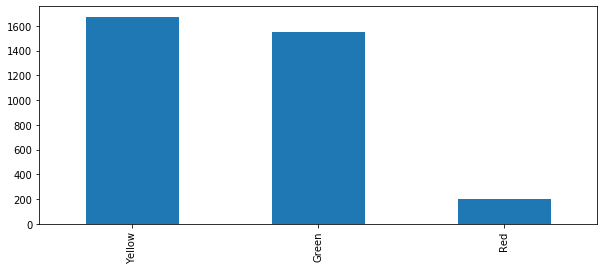

In [8]:
my_tags = ['Green','Yellow','Red']
plt.figure(figsize=(10,4))
data.labels.value_counts().plot(kind='bar');

In [9]:
def print_plot(index):
    example = data[data.index == index][['texts', 'labels']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label', example[1])

In [10]:
print_plot(10)

no placard placed - minor stucco cracks
Label Green


clean the data by removing special characters, and using stopwords

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sujit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [13]:
data['texts'] = data['texts'].apply(clean_text)

## Text data Visualization

In [14]:
import plotly.graph_objs as go
import chart_studio
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [15]:
data['word_count'] = data['texts'].apply(lambda x: len(str(x).split()))

In [16]:
data['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

In [17]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['texts'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['texts' , 'count'])
df2.groupby('texts').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

chimney 1174
damage 509
structure 399
good 345
cracks 344
wall 267
minor 241
cracking 225
roof 213
comments 194
cracked 193
foundation 175
area 162
use 159
tag 150
green 150
interior 148
exterior 145
damaged 139
stucco 138


In [18]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data['texts'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['texts' , 'count'])
df4.groupby('texts').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

structure good 330
green tag 92
stay clear 77
roof line 54
use fireplace 53
chimney damage 53
chimney cracked 52
structural damage 49
ok occupy 49
damaged chimney 49
minor cracks 48
falling hazard 48
chimney fell 47
chimney area 45
cracked chimney 44
clear chimney 44
stucco cracking 43
moderate damage 40
damage limited 39
bel aire 38


In [19]:
y0 = data.loc[data['labels'] == 'Red']


In [20]:
data.head()

,labels,texts,word_count
0,Yellow,noticable damages observed exterior chimney da...,9
1,Green,cracks wood ridge beam appear ordinary shrinka...,8
2,Green,cracks gypbd roof beam porch interior beam twi...,8
3,Green,minor cracks chimney home appears safe secure,7
4,Yellow,use front porch except enter exit home,7


Split the data into training and test set

In [21]:
X = data.texts
y = data.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

## Naive Bayes classifier for multinomial models

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [23]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)
y_pred_train = nb.predict(X_train)

print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8140214216163584
[[361 105   0]
 [ 32 469   0]
 [  6  48   6]]
---------------------------
Accuracy of training set 0.8860601001669449
[[ 977  109    0]
 [  35 1138    0]
 [  17  112    8]]
---------------------------
              precision    recall  f1-score   support

       Green       0.90      0.77      0.83       466
      Yellow       1.00      0.10      0.18        60
         Red       0.75      0.94      0.84       501

    accuracy                           0.81      1027
   macro avg       0.89      0.60      0.62      1027
weighted avg       0.84      0.81      0.80      1027

Wall time: 148 ms


## Support vector machine

In [24]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [25]:
%%time
from sklearn.metrics import classification_report
y_pred = sgd.predict(X_test)
y_pred_train = sgd.predict(X_train)

print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8442064264849075
[[390  76   0]
 [ 43 457   1]
 [  3  37  20]]
---------------------------
Accuracy of training set 0.9307178631051753
[[1020   66    0]
 [  29 1142    2]
 [  11   58   68]]
---------------------------
              precision    recall  f1-score   support

       Green       0.89      0.84      0.86       466
      Yellow       0.95      0.33      0.49        60
         Red       0.80      0.91      0.85       501

    accuracy                           0.84      1027
   macro avg       0.88      0.69      0.74      1027
weighted avg       0.85      0.84      0.84      1027

Wall time: 83.1 ms


## Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [27]:

y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

from sklearn.metrics import classification_report
print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))


Accuracy of test set 0.810126582278481
[[369  75  22]
 [ 52 429  20]
 [  2  24  34]]
---------------------------
Accuracy of training set 0.996661101836394
[[1083    2    1]
 [   1 1172    0]
 [   0    4  133]]
---------------------------
              precision    recall  f1-score   support

       Green       0.87      0.79      0.83       466
      Yellow       0.45      0.57      0.50        60
         Red       0.81      0.86      0.83       501

    accuracy                           0.81      1027
   macro avg       0.71      0.74      0.72      1027
weighted avg       0.82      0.81      0.81      1027



## Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

DT = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=0)),
               ])
DT.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                            

In [29]:
y_pred = DT.predict(X_test)
y_pred_train = DT.predict(X_train)

from sklearn.metrics import classification_report
print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.824732229795521
[[386  73   7]
 [ 53 429  19]
 [  4  24  32]]
---------------------------
Accuracy of training set 0.9970784641068448
[[1085    1    0]
 [   1 1170    2]
 [   1    2  134]]
---------------------------
              precision    recall  f1-score   support

       Green       0.87      0.83      0.85       466
      Yellow       0.55      0.53      0.54        60
         Red       0.82      0.86      0.84       501

    accuracy                           0.82      1027
   macro avg       0.75      0.74      0.74      1027
weighted avg       0.83      0.82      0.82      1027



## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

RF = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=200,  random_state=0)),
               ])
RF.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [31]:
y_pred = RF.predict(X_test)
y_pred_train = RF.predict(X_train)

from sklearn.metrics import classification_report
print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8558909444985394
[[395  67   4]
 [ 40 456   5]
 [  5  27  28]]
---------------------------
Accuracy of training set 0.9970784641068448
[[1085    1    0]
 [   1 1171    1]
 [   1    3  133]]
---------------------------
              precision    recall  f1-score   support

       Green       0.90      0.85      0.87       466
      Yellow       0.76      0.47      0.58        60
         Red       0.83      0.91      0.87       501

    accuracy                           0.86      1027
   macro avg       0.83      0.74      0.77      1027
weighted avg       0.86      0.86      0.85      1027



## ADABOOST

In [32]:
from sklearn.ensemble import AdaBoostClassifier

ADB = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(n_estimators=100, random_state=0)),
               ])
ADB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=100,
  

In [33]:
y_pred = ADB.predict(X_test)
y_pred_train = ADB.predict(X_train)

from sklearn.metrics import classification_report
print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.7867575462512172
[[402  62   2]
 [106 381  14]
 [  7  28  25]]
---------------------------
Accuracy of training set 0.8251252086811353
[[993  91   2]
 [234 912  27]
 [  9  56  72]]
---------------------------
              precision    recall  f1-score   support

       Green       0.78      0.86      0.82       466
      Yellow       0.61      0.42      0.50        60
         Red       0.81      0.76      0.78       501

    accuracy                           0.79      1027
   macro avg       0.73      0.68      0.70      1027
weighted avg       0.78      0.79      0.78      1027



## XGBOOST

In [34]:
from xgboost import XGBClassifier

XGB = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier()),
               ])
XGB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing

In [35]:
y_pred = XGB.predict(X_test)
y_pred_train = XGB.predict(X_train)

from sklearn.metrics import classification_report
print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8286270691333982
[[402  64   0]
 [ 67 429   5]
 [ 14  26  20]]
---------------------------
Accuracy of training set 0.8843906510851419
[[1022   63    1]
 [ 137 1032    4]
 [  28   44   65]]
---------------------------
              precision    recall  f1-score   support

       Green       0.83      0.86      0.85       466
      Yellow       0.80      0.33      0.47        60
         Red       0.83      0.86      0.84       501

    accuracy                           0.83      1027
   macro avg       0.82      0.68      0.72      1027
weighted avg       0.83      0.83      0.82      1027



## Light GBM

In [36]:
from lightgbm import LGBMClassifier

LGB = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier()),
               ])
LGB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split

In [37]:
y_pred = LGB.predict(X_test)
y_pred_train = LGB.predict(X_train)

from sklearn.metrics import classification_report
print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8490749756572541
[[392  65   9]
 [ 42 451   8]
 [  8  23  29]]
---------------------------
Accuracy of training set 0.9595158597662772
[[1066   18    2]
 [  53 1113    7]
 [  10    7  120]]
---------------------------
              precision    recall  f1-score   support

       Green       0.89      0.84      0.86       466
      Yellow       0.63      0.48      0.55        60
         Red       0.84      0.90      0.87       501

    accuracy                           0.85      1027
   macro avg       0.78      0.74      0.76      1027
weighted avg       0.85      0.85      0.85      1027



# Word2vec embedding 

In this section we convert text to vectors using word2vec and do the comparison of various machine learning models

In [38]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("C:\\Users\\sujit\\Documents\\GitHub\\Napa_Earthquake_Text_classification\\GoogleNews-vectors-negative300.bin.gz", binary=True)

wv.init_sims(replace=True)

# from smart_open import open  
# import smart_open
# smart_open.open('s3://commoncrawl/robots.txt', 'rb').read(32)
# b'User-Agent: *\nDisallow: /'

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



In [39]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [40]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [41]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [42]:
train, test = train_test_split(data, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['texts']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['texts']), axis=1).values

In [43]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['labels'])
y_pred = logreg.predict(X_test_word_average)
y_pred_train = logreg.predict(X_train_word_average)

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [45]:
print('Accuracy of test set %s' % accuracy_score(y_pred, test.labels))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8257059396299903
[[389  64  13]
 [ 53 422  26]
 [  5  18  37]]
---------------------------
Accuracy of training set 0.9620200333889817
[[1036   50    0]
 [  33 1139    1]
 [   3    4  130]]
---------------------------
              precision    recall  f1-score   support

       Green       0.87      0.83      0.85       466
      Yellow       0.49      0.62      0.54        60
         Red       0.84      0.84      0.84       501

    accuracy                           0.83      1027
   macro avg       0.73      0.76      0.75      1027
weighted avg       0.83      0.83      0.83      1027



In [46]:
X_train_word_average

array([[ 0.00246594,  0.0521712 , -0.0200479 , ..., -0.04671119,
         0.03036719,  0.0008012 ],
       [ 0.01803191,  0.07164127, -0.0925671 , ..., -0.04564193,
         0.04144321, -0.0265803 ],
       [ 0.00033761,  0.04973388, -0.03683099, ..., -0.10000218,
        -0.08678242, -0.03184164],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00806111,  0.05315241, -0.00610028, ..., -0.14680903,
         0.02909382, -0.0738406 ],
       [ 0.02789648,  0.02310111, -0.04271152, ..., -0.07185823,
         0.08289505, -0.07431073]])

In [47]:
# Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# MNB = MultinomialNB()
# MNB = MNB.fit(X_train_word_average, train['labels'])
# y_pred = MNB.predict(X_test_word_average)
# y_pred_train = MNB.predict(X_train_word_average)

## Support vector machine

In [48]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
SGD.fit(X_train_word_average, train['labels'])
y_pred = SGD.predict(X_test_word_average)
y_pred_train = SGD.predict(X_train_word_average)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [49]:
print('Accuracy of test set %s' % accuracy_score(y_pred, test.labels))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8120740019474196
[[357 105   4]
 [ 32 467   2]
 [ 10  40  10]]
---------------------------
Accuracy of training set 0.8626878130217028
[[ 913  172    1]
 [  47 1113   13]
 [  19   77   41]]
---------------------------
              precision    recall  f1-score   support

       Green       0.89      0.77      0.83       466
      Yellow       0.62      0.17      0.26        60
         Red       0.76      0.93      0.84       501

    accuracy                           0.81      1027
   macro avg       0.76      0.62      0.64      1027
weighted avg       0.81      0.81      0.80      1027



## Decision TREE

In [50]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(X_train_word_average, train['labels'])
y_pred = DT.predict(X_test_word_average)
y_pred_train = DT.predict(X_train_word_average)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [51]:
print('Accuracy of test set %s' % accuracy_score(y_pred, test.labels))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.7896786757546251
[[371  87   8]
 [ 56 414  31]
 [  9  25  26]]
---------------------------
Accuracy of training set 0.9962437395659433
[[1085    1    0]
 [   2 1169    2]
 [   2    2  133]]
---------------------------
              precision    recall  f1-score   support

       Green       0.85      0.80      0.82       466
      Yellow       0.40      0.43      0.42        60
         Red       0.79      0.83      0.81       501

    accuracy                           0.79      1027
   macro avg       0.68      0.69      0.68      1027
weighted avg       0.79      0.79      0.79      1027



## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

RF =  RandomForestClassifier(n_estimators=200,  random_state=0)
RF.fit(X_train_word_average, train['labels'])
y_pred = RF.predict(X_test_word_average)
y_pred_train = RF.predict(X_train_word_average)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [53]:
print('Accuracy of test set %s' % accuracy_score(y_pred, test.labels))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8364167478091529
[[369  95   2]
 [ 30 471   0]
 [  8  33  19]]
---------------------------
Accuracy of training set 0.9962437395659433
[[1085    1    0]
 [   2 1171    0]
 [   2    4  131]]
---------------------------
              precision    recall  f1-score   support

       Green       0.91      0.79      0.85       466
      Yellow       0.90      0.32      0.47        60
         Red       0.79      0.94      0.86       501

    accuracy                           0.84      1027
   macro avg       0.87      0.68      0.72      1027
weighted avg       0.85      0.84      0.83      1027



## ADABOOST

In [54]:
from sklearn.ensemble import AdaBoostClassifier

ADB = AdaBoostClassifier(n_estimators=100, random_state=0)
ADB.fit(X_train_word_average, train['labels'])
y_pred = ADB.predict(X_test_word_average)
y_pred_train = ADB.predict(X_train_word_average)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [55]:
print('Accuracy of test set %s' % accuracy_score(y_pred, test.labels))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.7555988315481986
[[345 117   4]
 [ 90 405   6]
 [  5  29  26]]
---------------------------
Accuracy of training set 0.833889816360601
[[908 177   1]
 [166 993  14]
 [  2  38  97]]
---------------------------
              precision    recall  f1-score   support

       Green       0.78      0.74      0.76       466
      Yellow       0.72      0.43      0.54        60
         Red       0.74      0.81      0.77       501

    accuracy                           0.76      1027
   macro avg       0.75      0.66      0.69      1027
weighted avg       0.76      0.76      0.75      1027



## XGBOOST

In [56]:
from xgboost import XGBClassifier

XGB =  XGBClassifier()
XGB.fit(X_train_word_average, train['labels'])
y_pred = XGB.predict(X_test_word_average)
y_pred_train = XGB.predict(X_train_word_average)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [57]:
print('Accuracy of test set %s' % accuracy_score(y_pred, test.labels))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8432327166504382
[[375  89   2]
 [ 32 468   1]
 [  6  31  23]]
---------------------------
Accuracy of training set 0.9753756260434057
[[1048   38    0]
 [   6 1166    1]
 [   2   12  123]]
---------------------------
              precision    recall  f1-score   support

       Green       0.91      0.80      0.85       466
      Yellow       0.88      0.38      0.53        60
         Red       0.80      0.93      0.86       501

    accuracy                           0.84      1027
   macro avg       0.86      0.71      0.75      1027
weighted avg       0.85      0.84      0.84      1027



## Light GBM

In [58]:
from lightgbm import LGBMClassifier

LGB =  LGBMClassifier()
LGB.fit(X_train_word_average, train['labels'])
y_pred = LGB.predict(X_test_word_average)
y_pred_train = LGB.predict(X_train_word_average)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [59]:
print('Accuracy of test set %s' % accuracy_score(y_pred, test.labels))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(y_pred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8422590068159689
[[381  83   2]
 [ 32 464   5]
 [  5  35  20]]
---------------------------
Accuracy of training set 0.9962437395659433
[[1085    1    0]
 [   2 1170    1]
 [   2    3  132]]
---------------------------
              precision    recall  f1-score   support

       Green       0.91      0.82      0.86       466
      Yellow       0.74      0.33      0.46        60
         Red       0.80      0.93      0.86       501

    accuracy                           0.84      1027
   macro avg       0.82      0.69      0.73      1027
weighted avg       0.85      0.84      0.84      1027



# Doc2vec 

Doc2vec, taking the linear combination of every term in the document creates a random walk with bias process in the word2vec space

In [60]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [61]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data.texts, data.labels, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [63]:
all_data[1:5]

[TaggedDocument(words=['playful', 'gardner'], tags=['Train_1']),
 TaggedDocument(words=['chimney', 'damage'], tags=['Train_2']),
 TaggedDocument(words=['structure', 'good'], tags=['Train_3']),
 TaggedDocument(words=['structure', 'good'], tags=['Train_4'])]

In [64]:

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 3423/3423 [00:00<00:00, 73327.97it/s]


In [65]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3423/3423 [00:00<00:00, 1795760.17it/s]


In [66]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [67]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

## LOGISTIC REGRESSION

In [68]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
ypred_train = logreg.predict(train_vectors_dbow)

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\sujit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [70]:
from sklearn.metrics import classification_report


print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(ypred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.7974683544303798
[[377  72   9]
 [ 75 409  28]
 [  2  22  33]]
---------------------------
Accuracy of training set 0.9115191986644408
[[489 537  68]
 [531 575  56]
 [ 69  62   9]]
---------------------------
              precision    recall  f1-score   support

       Green       0.83      0.82      0.83       458
      Yellow       0.47      0.58      0.52        57
         Red       0.81      0.80      0.81       512

    accuracy                           0.80      1027
   macro avg       0.70      0.73      0.72      1027
weighted avg       0.80      0.80      0.80      1027



In [71]:
# # Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# MNB = MultinomialNB()
# MNB = MNB.fit(train_vectors_dbow, y_train)
# y_pred = MNB.predict(test_vectors_dbow)
# ypred_train = MNB.predict(train_vectors_dbow)

## Support Vector Machine

In [72]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
SGD.fit(train_vectors_dbow, y_train)
y_pred = SGD.predict(test_vectors_dbow)
ypred_train = SGD.predict(train_vectors_dbow)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [73]:
from sklearn.metrics import classification_report


print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(ypred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.7497565725413826
[[350 108   0]
 [ 95 416   1]
 [  7  46   4]]
---------------------------
Accuracy of training set 0.7662771285475793
[[489 537  68]
 [531 575  56]
 [ 69  62   9]]
---------------------------
              precision    recall  f1-score   support

       Green       0.77      0.76      0.77       458
      Yellow       0.80      0.07      0.13        57
         Red       0.73      0.81      0.77       512

    accuracy                           0.75      1027
   macro avg       0.77      0.55      0.56      1027
weighted avg       0.75      0.75      0.73      1027



## Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_vectors_dbow, y_train)
y_pred = DT.predict(test_vectors_dbow)
ypred_train = DT.predict(train_vectors_dbow)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [75]:
from sklearn.metrics import classification_report


print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(ypred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.7526777020447907
[[352  87  19]
 [ 82 398  32]
 [  9  25  23]]
---------------------------
Accuracy of training set 1.0
[[489 537  68]
 [531 575  56]
 [ 69  62   9]]
---------------------------
              precision    recall  f1-score   support

       Green       0.79      0.77      0.78       458
      Yellow       0.31      0.40      0.35        57
         Red       0.78      0.78      0.78       512

    accuracy                           0.75      1027
   macro avg       0.63      0.65      0.64      1027
weighted avg       0.76      0.75      0.76      1027



## Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

RF =  RandomForestClassifier(n_estimators=200,  random_state=0)
RF.fit(train_vectors_dbow, y_train)
y_pred = RF.predict(test_vectors_dbow)
ypred_train = RF.predict(train_vectors_dbow)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [77]:
from sklearn.metrics import classification_report


print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(ypred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8519961051606622
[[384  74   0]
 [ 37 473   2]
 [  4  35  18]]
---------------------------
Accuracy of training set 1.0
[[489 537  68]
 [531 575  56]
 [ 69  62   9]]
---------------------------
              precision    recall  f1-score   support

       Green       0.90      0.84      0.87       458
      Yellow       0.90      0.32      0.47        57
         Red       0.81      0.92      0.86       512

    accuracy                           0.85      1027
   macro avg       0.87      0.69      0.73      1027
weighted avg       0.86      0.85      0.84      1027



## ADABOOST

In [78]:
from sklearn.ensemble import AdaBoostClassifier

ADB = AdaBoostClassifier(n_estimators=100, random_state=0)
ADB.fit(train_vectors_dbow, y_train)
y_pred = ADB.predict(test_vectors_dbow)
ypred_train = ADB.predict(train_vectors_dbow)



AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [79]:
from sklearn.metrics import classification_report


print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(ypred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8052580331061344
[[359  98   1]
 [ 59 444   9]
 [  2  31  24]]
---------------------------
Accuracy of training set 0.8021702838063439
[[489 537  68]
 [531 575  56]
 [ 69  62   9]]
---------------------------
              precision    recall  f1-score   support

       Green       0.85      0.78      0.82       458
      Yellow       0.71      0.42      0.53        57
         Red       0.77      0.87      0.82       512

    accuracy                           0.81      1027
   macro avg       0.78      0.69      0.72      1027
weighted avg       0.81      0.81      0.80      1027



## XGBOOST

In [80]:
from xgboost import XGBClassifier

XGB =  XGBClassifier()
XGB.fit(train_vectors_dbow, y_train)
y_pred = XGB.predict(test_vectors_dbow)
ypred_train = XGB.predict(train_vectors_dbow)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [81]:
from sklearn.metrics import classification_report


print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(ypred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8451801363193768
[[391  65   2]
 [ 48 455   9]
 [  3  32  22]]
---------------------------
Accuracy of training set 0.9419866444073456
[[489 537  68]
 [531 575  56]
 [ 69  62   9]]
---------------------------
              precision    recall  f1-score   support

       Green       0.88      0.85      0.87       458
      Yellow       0.67      0.39      0.49        57
         Red       0.82      0.89      0.86       512

    accuracy                           0.85      1027
   macro avg       0.79      0.71      0.74      1027
weighted avg       0.84      0.85      0.84      1027



## Light GBM

In [82]:
from lightgbm import LGBMClassifier

LGB =  LGBMClassifier()
LGB.fit(train_vectors_dbow, y_train)
y_pred = LGB.predict(test_vectors_dbow)
ypred_train = LGB.predict(train_vectors_dbow)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [83]:
from sklearn.metrics import classification_report


print('Accuracy of test set %s' % accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred, my_tags))
print('---------------------------')
print('Accuracy of training set %s' % accuracy_score(ypred_train, y_train))
print(confusion_matrix(y_train, y_pred_train,my_tags))
print('---------------------------')
print(classification_report(y_test, y_pred,target_names=my_tags))

Accuracy of test set 0.8588120740019474
[[398  59   1]
 [ 46 461   5]
 [  4  30  23]]
---------------------------
Accuracy of training set 1.0
[[489 537  68]
 [531 575  56]
 [ 69  62   9]]
---------------------------
              precision    recall  f1-score   support

       Green       0.89      0.87      0.88       458
      Yellow       0.79      0.40      0.53        57
         Red       0.84      0.90      0.87       512

    accuracy                           0.86      1027
   macro avg       0.84      0.72      0.76      1027
weighted avg       0.86      0.86      0.85      1027



## BOW with keras

In [84]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [85]:
train_size = int(len(data) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 2396
Test size: 1027


In [86]:
train_posts = data['texts'][:train_size]
train_tags = data['labels'][:train_size]

test_posts = data['texts'][train_size:]
test_tags = data['labels'][train_size:]

In [87]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [88]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [89]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

LabelEncoder()

In [90]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [91]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2396, 1000)
x_test shape: (1027, 1000)
y_train shape: (2396, 3)
y_test shape: (1027, 3)


In [92]:
batch_size = 32
epochs = 2

In [93]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [94]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 2156 samples, validate on 240 samples
Epoch 1/2
2156/2156 [==============================] - ETA: 5:47 - loss: 1.0651 - accuracy: 0.50 - ETA: 1:54 - loss: 1.0646 - accuracy: 0.52 - ETA: 46s - loss: 1.0339 - accuracy: 0.5938 - ETA: 25s - loss: 0.9890 - accuracy: 0.648 - ETA: 13s - loss: 0.9405 - accuracy: 0.687 - ETA: 9s - loss: 0.9008 - accuracy: 0.708 - ETA: 6s - loss: 0.8620 - accuracy: 0.73 - ETA: 4s - loss: 0.8298 - accuracy: 0.74 - ETA: 3s - loss: 0.7954 - accuracy: 0.75 - ETA: 2s - loss: 0.7704 - accuracy: 0.76 - ETA: 1s - loss: 0.7506 - accuracy: 0.76 - ETA: 0s - loss: 0.7250 - accuracy: 0.77 - ETA: 0s - loss: 0.7072 - accuracy: 0.77 - 6s 3ms/step - loss: 0.7020 - accuracy: 0.7788 - val_loss: 0.4521 - val_accuracy: 0.8542
Epoch 2/2
2156/2156 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.87 - ETA: 0s - loss: 0.4484 - accuracy: 0.84 - ETA: 0s - loss: 0.4331 - accuracy: 0.84 - ETA: 0s - loss: 0.4061 - accuracy: 0.85 - ETA: 0s - loss: 0.4037 - accu

In [95]:
score = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

1027/1027 [==============================] - ETA:  - 0s 35us/step
Test accuracy: 0.8354430198669434


In [96]:
print(score)

[0.42884670586815826, 0.8354430198669434]
